# Base agent - This agent is called when no specialized agent is available for the topic

In [131]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage


def generic_agent(state, llm):
    
    query = state.get("query", "")
    if not query:
        return {"messages": state.get("messages", []), "query": query}
    
    
    past_messages = state.get("messages", [])
    role = state.get("role", "assistant")  # Default to 'assistant' if not provided

    # Optional: Modify system prompt based on role
    system_prompt = SystemMessage(
        content=f"You are a helpful AI assistant playing the role of '{role}'. Respond to the user's query as best as you can."
    )

    # Construct full conversation: system prompt + past history + current query
    message_history = [system_prompt] + past_messages + [HumanMessage(content=query)]

    # Get the model's response
    response = llm.invoke(message_history)

    # Update state with current turn
    state["messages"].append(HumanMessage(content=query))
    state["messages"].append(response)  # response is already AIMessage

    # Optional: you could update the role dynamically too if needed
    state["role"] = role

    return state

# Weather tool- This tool invokes the weather API to get the weather at a place on a date

In [132]:

#Weather Agent that uses the OpenWeatherMap API.
import os
from langchain_core.tools import tool
import requests
import re
from geopy.geocoders import Nominatim

"""
A tool that fetches real-time weather data from the OpenWeatherMap API.
"""

@tool
def get_weather_forecast(query: str) -> str:
    '''weather forecast tool
        args:
            query
        output:
            weather/error
    '''
    api_key = os.getenv("WEATHER_API_KEY")
    geolocator = Nominatim(user_agent="weather-agent") # get lat/long of a place
    location = extract_location(query) 
    geo = geolocator.geocode(location)
    
    if not geo:
        return "Could not determine the location."
    response = requests.get(
        f"http://api.openweathermap.org/data/2.5/forecast",
        params={"lat": geo.latitude, "lon": geo.longitude, "appid": api_key} 
    )
    data = response.json()
    print("weather tool response" , f"{location} weather : {data['list'][0]['weather'][0]['description']} at {data['list'][0]['main']['temp']}°C")
    return f"{location} weather : {data['list'][0]['weather'][0]['description']} at {data['list'][0]['main']['temp']}°C"

# simple regex based routine to extract , can use a simple llm model for entity extraction
def extract_location(query: str) -> str:
    match = re.search(r"in\s+([A-Za-z\s]+)", query, re.IGNORECASE)
    if match:
        return match.group(1).strip()
    words = query.split()
    return words[-1] if words else None



# Fashion tool- This is a tool for fetching the latest fashion trend

In [133]:
from langchain_core.tools import tool
# not implemented fully, could not get the right API for this
@tool
def get_fashion_trend(inquiry: str):
    """Call to get the fashion trend."""
    # This is a placeholder for the actual implementation, LLM cares about the response from this tool
    if any([dress in inquiry.lower() for dress in ["wear", "dress", 'cloth', 'trend', 'fashion']]):
        return "Florals are the best!"
    else:
        return f"I am not sure I know how to answer {inquiry}"
tools = [get_weather_forecast, get_fashion_trend]
print(tools)


[StructuredTool(name='get_weather_forecast', description='weather forecast tool\n        args:\n            query\n        output:\n            weather/error', args_schema=<class 'langchain_core.utils.pydantic.get_weather_forecast'>, func=<function get_weather_forecast at 0x10d51dd00>), StructuredTool(name='get_fashion_trend', description='Call to get the fashion trend.', args_schema=<class 'langchain_core.utils.pydantic.get_fashion_trend'>, func=<function get_fashion_trend at 0x10d51e5c0>)]


# Weather agent- This is the weather agent that specializes in getting weather related details

In [134]:
def weather_agent(state, llm_with_tools):
    query = state.get("query", "")
    role = state.get("role", "weather_specialist")
    past_messages = state.get("messages", [])

    # Call the tool manually first
    tool_result = get_weather_forecast(query)
    if "Unknown" in tool_result or not tool_result:
        tool_result = "I'm sorry, I couldn't get accurate weather info."

    # for case where the weather API does not return results
    system_prompt = SystemMessage(
    content=(
        "You are a weather specialist. When the user asks about the weather, "
        "you should first try to use the weather tool to fetch real-time data.\n\n"
        "If the tool fails to return valid data (e.g. says 'Unknown location' or gives no result or says I'm sorry,), "
        "then use your own knowledge and reasoning to respond helpfully. "
        "Always make sure your answer is informative and natural."
    )
)
    # Construct the full message history
    message_history = [system_prompt] + past_messages + [HumanMessage(content=query)]

    # invokes the weather tool and uses its response to form the final response from LLM
    response = llm_with_tools.invoke(message_history) 
    
    # Update state with current turn
    state["messages"].append(HumanMessage(content=query))
    state["messages"].append(response)  # response is already AIMessage

    # Optional: you could update the role dynamically too if needed
    state["role"] = role

    return state

# Fashion agent- This is fashion agent specializes in getting latest fashion trends

In [135]:
def fashion_agent(state, llm_with_tools):
    query = state["query"]
    past_messages = state.get("messages", [])
    role = state.get("role", "fashion_specialist")
    
    # Construct the full message history
    message_history = [system_prompt] + past_messages + [HumanMessage(content=query)]

    system_prompt = SystemMessage(
    content=(
        "You are a fashion specialist. When the user asks about the fashion trend, "
        "you should first try to use the fashion tool to fetch real-time data.\n\n"
        "If the tool fails to return valid data (e.g. says 'Unknown' or gives no result or says 'I'm sorry',), "
        "then use your own knowledge and reasoning to respond helpfully. "
        "Always make sure your answer is informative and natural."
    )
)
    response = llm_with_tools.invoke(message_history)
    
    # Update state with current turn
    state["messages"].append(HumanMessage(content=query))
    state["messages"].append(response)  # response is already AIMessage

    # Optional: you could update the role dynamically too if needed
    state["role"] = role

    return state

# State for the chat session

In [136]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class WeathermindState(TypedDict):
    messages: Annotated[list, add_messages] # conversation history
    query: str
    role: str


# This is the LLM that powers the agents bound to the tools

In [137]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import os


load_dotenv()

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.7,
    google_api_key=os.getenv("GEMINI_API_KEY"),
)

# Bind tools to LLM
llm_with_tools = llm.bind_tools(tools) 


# Create all the nodes to be orchestrated

In [138]:
graph = StateGraph(WeathermindState)

# Nodes
def start_node(state: WeathermindState) -> WeathermindState:
    print("Start node initialized.")
    return state

def weather_node(state: WeathermindState) -> WeathermindState:
    print("Weather node initialized.")
    return weather_agent(state, llm_with_tools)

def fashion_node(state: WeathermindState) -> WeathermindState:
    print("Fashion node initialized.")
    return fashion_agent(state, llm_with_tools)

def generic_node(state: WeathermindState) -> WeathermindState:
    print("Generic node initialized.")
    return generic_agent(state, llm)

# This is the main program that builds the graph

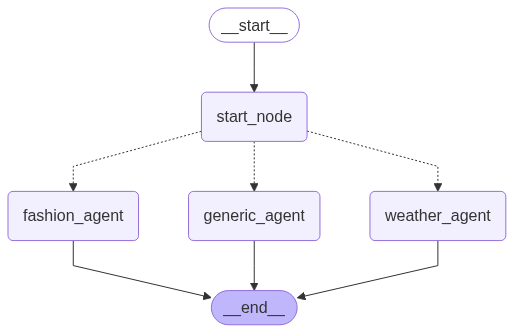

In [139]:
# Define the state with conversation memory

def initialize_state(user_input, memory=None):
    wmstate = WeathermindState(
    query=user_input,
    messages=memory
    )
    return wmstate

# Router
# can be improved with spaCy to analyze query or a dedicated machine learning classifier
def route_question(state):
    query = state["query"].lower()
    if "weather" in query or "rain" in query:
        return "weather_agent"
    elif "cloth" in query or "wear" in query or "fashion" in query:
        return "fashion_agent"
    else:
        return "generic_agent"

# Graph setup
# This graph has a start node, one of the agents based on the type of query
# I could not try out mix of agents based on query
# I also could not full try out different roles of agents but have started it in the weather_mind_multi_agent.ipynb notebook
graph.add_node("start_node", start_node)
graph.add_node("weather_agent", weather_node)
graph.add_node("fashion_agent", fashion_node)
graph.add_node("generic_agent", generic_node)

graph.add_edge(START, "start_node")
graph.add_conditional_edges("start_node", route_question, {
    "weather_agent": "weather_agent",
    "fashion_agent": "fashion_agent",
    "generic_agent": "generic_agent",
})

# Each agent returns updated 'messages' list
graph.add_edge("weather_agent", END)
graph.add_edge("fashion_agent", END)
graph.add_edge("generic_agent", END)

# Use MemorySaver (in-memory for now)
memory = MemorySaver()

workflow = graph.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# This is the conversational chat interface 

In [140]:
from langchain_core.runnables import RunnableConfig   
def chat():
    print("🌤️ Hi! Ask me about weather, offers, or anything general.")
    conversation_memory = []

    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit"]:
            print("👋 Goodbye!")
            break

        state = initialize_state(user_input, conversation_memory)
        print("Human input------------------:", user_input)
        config = RunnableConfig(
            {
                "configurable": {
                    "thread_id": "1",
                },
            }
          )
        result = workflow.invoke(state, config=config)
        print("---------------------------------")
        if result["messages"]:
            print(result["messages"][-1].content)
        else:
            print("No messages available.")
# start chat
#global state
chat()

🌤️ Hi! Ask me about weather, offers, or anything general.
Human input------------------: How is Guwahati City?
Start node initialized.
Generic node initialized.
---------------------------------
Guwahati is the largest city in Assam and Northeast India, and it's often called the "Gateway to the Northeast." Here's a general overview of what it's like:

**Pros:**

*   **Natural Beauty:** Surrounded by hills and with the Brahmaputra River flowing through it, Guwahati offers beautiful scenery.
*   **Cultural Hub:** It's a center for Assamese culture, with temples like Kamakhya, museums, and historical sites.
*   **Food:** You can find delicious Assamese cuisine, known for its unique flavors and use of local ingredients.
*   **Transportation Hub:** Guwahati is well-connected to other parts of Northeast India and the rest of the country by air, rail, and road.
*   **Developing City:** It's a growing city with increasing opportunities in various sectors.

**Cons:**

*   **Traffic:** As a rapi